<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/Fundus-eye-disease-detection/Res_Mob_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#  MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [5]:
#  DEFINE DATASET PATHS
DATA_DIR = '/content/drive/MyDrive/data set/dataset'
FEATURE_DIR = '/content/drive/MyDrive/extracted_feature'

#  FUNCTION TO GET IMAGE DIRECTORIES
def get_class_directories(base_directory):
    return {folder_name: os.path.join(base_directory, folder_name) for folder_name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, folder_name))}


image_directories = get_class_directories(DATA_DIR) # capture the return value here
class_names = list(image_directories.keys())
print(f"Classes found: {class_names}")

Classes found: ['diabetic_retinopathy', 'normal', 'glaucoma', 'cataract']


In [6]:
#  SPLIT DATASET INTO TRAIN & TEST (Removed incorrect stratification)
train_dirs, test_dirs = {}, {}
for category, dir_path in image_directories.items():
    img_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
    train_files, test_files = train_test_split(img_files, test_size=0.2, random_state=42)
    train_dirs[category] = train_files
    test_dirs[category] = test_files

📂 First 5 Images from Each Category (Train & Test):

🔸 Category: diabetic_retinopathy
🔸 Category: normal
🔸 Category: glaucoma
🔸 Category: cataract


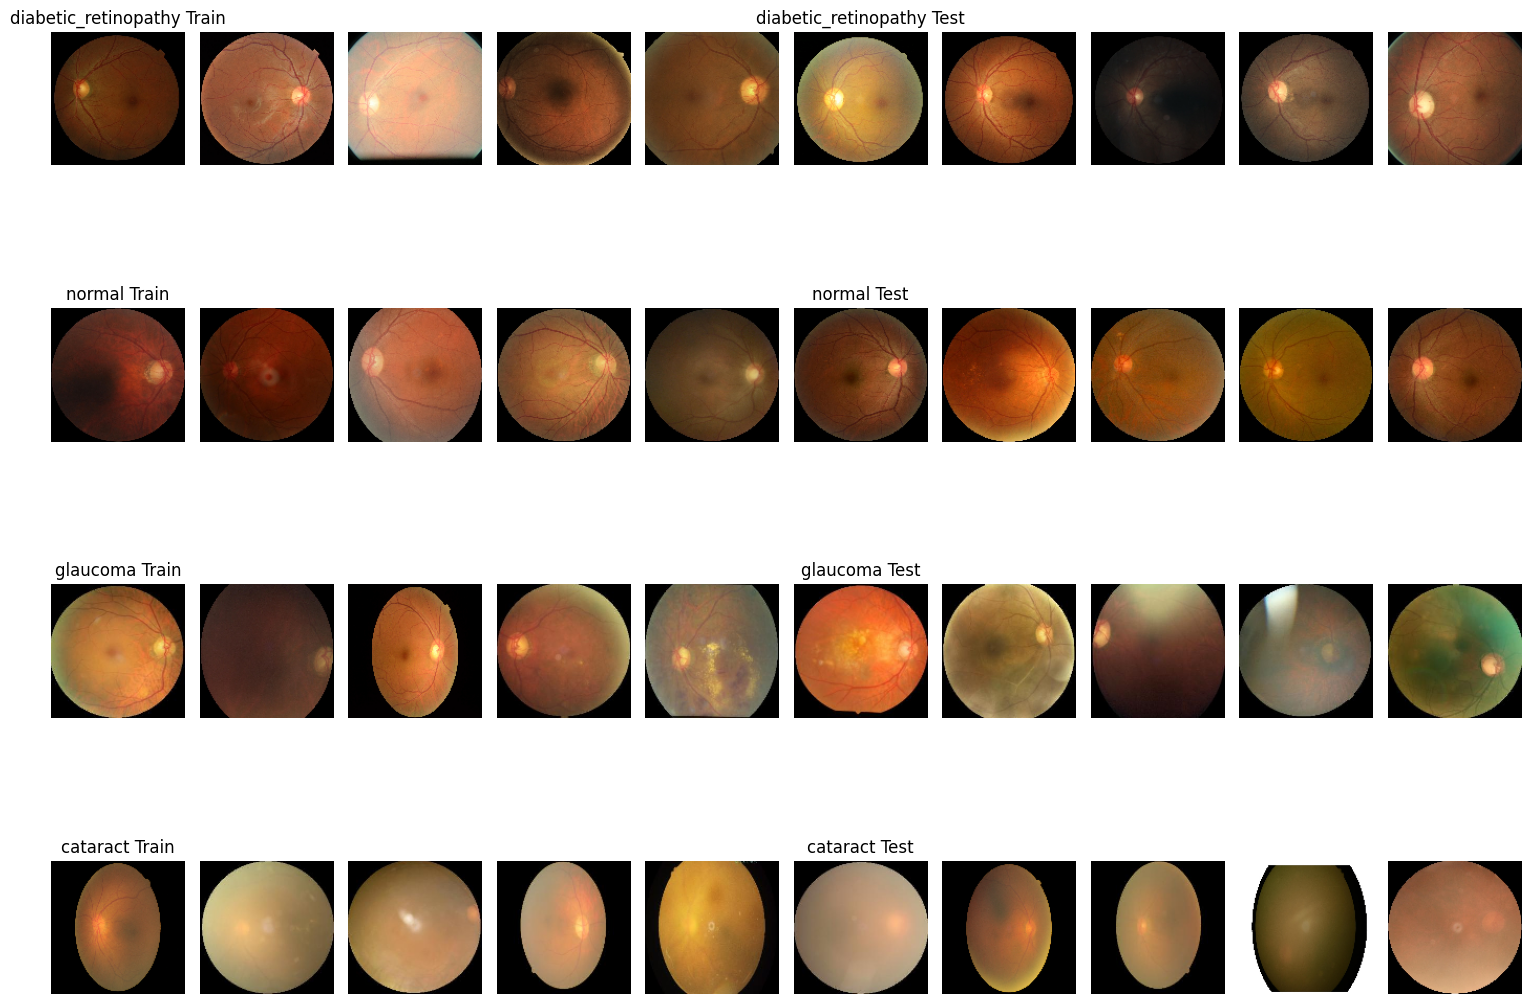

NameError: name 'pd' is not defined

In [7]:
# Display first 5 images from each category
def display_first_five_images(train_dirs, test_dirs):
    print("📂 First 5 Images from Each Category (Train & Test):\n")

    num_categories = len(train_dirs)
    fig, axes = plt.subplots(num_categories, 10, figsize=(15, num_categories * 3))

    for i, category in enumerate(train_dirs.keys()):
        print(f"🔸 Category: {category}")

        for j, img_path in enumerate(train_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{category} Train', fontsize=12)

        for j, img_path in enumerate(test_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j + 5].imshow(img)
            axes[i, j + 5].axis('off')
            if j == 0:
                axes[i, j + 5].set_title(f'{category} Test', fontsize=12)

    plt.tight_layout()
    plt.show()

display_first_five_images(train_dirs, test_dirs)

# Plot class distribution
def plot_class_distribution(train_dirs, test_dirs, class_names):
    train_counts = {category: len(files) for category, files in train_dirs.items()}
    test_counts = {category: len(files) for category, files in test_dirs.items()}

    df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts})
    df_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Class Distribution in Train and Test Sets')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_class_distribution(train_dirs, test_dirs, class_names)
